# Machine Learning Project - Cryptocurrencies price variations prediction

In [13]:
#import usefull packages
import pandas as pd
import numpy as np
from numpy import absolute
import matplotlib.pyplot as plt
import glob
import ta
import collections
import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import plotly.express as px



## See below for detailed steps of the following function (step by step, plots, comments...)

In [14]:
def features_selection(crypto_csv_file):
    
    
    # load data 
    Crypto = pd.read_csv(crypto_csv_file) 
    
    #get the name of the crypto 
    crypto_name = Crypto["Name"][0]
    #print(crypto_name)
    
    # Clean nan values
    Crypto = ta.utils.dropna(Crypto)

    # Add all technical analysis features filling nans values
    Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)
    
    # List of our indicators 
    indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']
    
    # compute the returns 
    Crypto["Returns"] = Crypto["Close"].pct_change()

    # keep only the relevant columns, ie. the ta indicators and the returns. 
    Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN
    
    # standardize
    sc = StandardScaler()
    Z_Crypto = sc.fit_transform(Crypto)
    
    # Lasso regression (alpha = 1.0)
    from sklearn.linear_model import Lasso
    regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
    
    # Rename for clarity 
    # We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date
    X,y = pd.DataFrame(Z_Crypto[:-1,:-1]),pd.DataFrame(Z_Crypto[1:,-1:])
    
    # fit
    regLasso1.fit(X,y)
    
    # obtain coeffficients of the LASSO regression for multiple alphas
    from sklearn.linear_model import lasso_path
    alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)

    # number of non-nul coefficients for each alpha
    nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
    alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})
    
    # get the alpha for which we get 8 selected features (and its index)
    # If no such alpha exists, choose an alpha for which we get 7 selected features, etc...
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    while np.isnan(higher_alpha_to_get_8_features) == True :
        alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
        higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
        
    # get the 8 selected features coressponding 
    coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
    index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
    coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
    selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
    
    X,y = Crypto[selected_features], Crypto['Returns']
    
    return crypto_name, selected_features, X, y
    
  

#### Run the Features Selection

In [15]:
# get a list of all csv files 
path = "/Users/diego/OneDrive/Bureau/GitHub/ML_Finance/Crypto df"
all_cryptos_csv_files = glob.glob(path + "/*.csv" )

# initialize dictionary with final selected features for each crypto
selected_features_per_crypto = {}
X_per_crypto = {}
y_per_crypto = {}

# get all selected features for each crpytocurrency 
for crypto_csv_file in all_cryptos_csv_files:
    
    crypto_name, features, X, y = features_selection(crypto_csv_file)
    
    # add selected features, X, and y to the dictionaries,
    selected_features_per_crypto[crypto_name] = features
    X_per_crypto[crypto_name] = X
    y_per_crypto[crypto_name] = y
    

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16882176940322324, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15572037797181792, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1483769470303855, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2559383082264901, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27073961838985383, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.283744105510948, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\m

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4132119316870728, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4153736482511192, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41881728787436145, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.419252646377032, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.308892968036332, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.236696542596718, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.111414409599746, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1813486280709355, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2486343305741343, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\my

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8441740204727353, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8743915410173315, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9058220961685208, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\m

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.30448850994145, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2752456337262856, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2428003830302714, tolerance: 0.027241083588690665
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\mye

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39660549662403355, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4022161875350321, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4016633714600175, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4696510964377012, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46766067819862656, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46562751431770266, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1619584060820216, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.240755189456877, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.276984671197397, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.535064028566694, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5263454220644235, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5166116468301425, tolerance: 0.1440958879019108
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38431108147096893, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3834087611448922, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38250193838212, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1724985623632165, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1958471270154405, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2207187257927217, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2924596450698118, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2913770647105594, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3009054989979632, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.86171060346669, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.074891315506193, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.98164532297733, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.78578940730995, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.85551505633907, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.769725906387976, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16270076317005078, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1572599935211656, tolerance: 

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2798511118278384, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.831286081660892, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1939385809398573, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5934757052239092, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8858444893833166, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0332874933660605, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3410639362546135, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.602500364049092, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.085109534615185, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.362016834050337, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.48768611368007, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.597002286227166, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.27194099030544, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.145857522985125, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.01809427767762, tolerance: 0.13670896372094818
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24892037164318026, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34752555514728556, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30765636015826203, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\m

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3354693556273105, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33501497303655015, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34745810947015343, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\my

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6054893001326036, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7617998931916645, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.806552999508085, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.518422603110594, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4863049353919, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.434138504187558, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9789638543095407, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.935348915377517, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.892885338854967, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.552847199627195, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.51769097995475, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.478972934479316, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.411299760958855, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.545268044028035, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.678107601067495, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.139707433433614, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.22670047143788, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.314077787326369, tolerance: 0.13817855621679168
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8866823034672962, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8037187106523334, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6867220442751432, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0602899849792493, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0647656771810716, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0643908897993697, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3908418240915807, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3812171693167556, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.373411201767908, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4279488279070165, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.026448588906874, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.575572842374868, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.618031476084752, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.40557266642088, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.194698724676982, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.8019666472008, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.273259890434247, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.729537137980287, tolerance: 0.07953806087835331
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1073603107300869, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10690297994528919, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10514521678317124, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\my

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3167241183319902, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31484301107707324, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31511644044496734, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\my

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9351163314893256, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9304617802104076, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9258681095121801, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.373673359256486, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.31582957369767, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.207686053264922, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.570633407782964, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.26487261204949, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.69914929900125, tolerance: 0.09298131016131239
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7185850601949824, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.734276383770066, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.746271278535005, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6635152435437703, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.677120663592632, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6921633273750558, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.801015286815982, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7984017043736458, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7954502431143737, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6965007659750881, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.693114807875645, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7513778718516733, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.80667949866847, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.76543959303808, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.13023672162126, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.197113458084, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214.15042803880397, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.19320988444952, tolerance: 0.2746495528201895
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21162914297565294, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22048827909884494, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21353662110527694, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\m

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19691618496995034, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1973358492632542, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19385928832366517, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\my

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22098422201975154, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23055339862276014, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23213193186029457, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\m

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7637255997378816, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9937954172057744, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0330708572087133, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9451154060980116, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1144394851023662, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2615868235441212, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.720109058700928, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.133843413521618, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.507884555280953, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.632284499530215, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.75771927232984, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.71855895916076, tolerance: 0.14582900460923662
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23339566450999882, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23318583073046284, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24278989420736252, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\m

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.520615359632302, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5120287222248407, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5080374738245155, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6403576332027114, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.098086321664596, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.536957963441637, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.943143335644436, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.642175953470996, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.874486023204327, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.911165720590134, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.265190060378018, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.886364364094334, tolerance: 0.21576235566440097
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23617556021986275, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45064174642334365, tolerance:

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5937469237439927, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5919417114180305, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5643623907260462, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4105900351476066, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5335419356965758, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.471920605087007, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8650845395586657, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8621171274896824, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8591014012624782, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7965790465714235, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7936642384036077, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7907529857400277, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7153364896025778, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6582424279406496, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.43359093430945, tolerance: 0.14645951355897302
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0174230551388064, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6664415794161869, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4977418073417539, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6682676988225467, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0308947509788595, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.258432586721483, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.83038547831984, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.858726600618866, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.630219008592576, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.566263814728245, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.545294185965304, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5318453572676844, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.450899538801423, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.253382574468105, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.281220636257331, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.339496052702543, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.431043621430945, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.475974762633086, tolerance: 0.27476898858556054
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1033230966918381, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1001710095069939, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1016507481385815, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.776329363842251, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.56823089240197, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.247046162462084, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.718643925356446, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.91624640264672, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.990588690320237, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.829258356733135, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.489679151150995, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.20154839888846, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.96678540960579, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.86724263901533, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.6153527418196, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.59991398704483, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.11636978947763, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201.61557020327882, tolerance: 0.25665547170171094
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3694432374009011, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37255506196834176, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33774637812757646, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\my

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7033991882967712, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6667537569110209, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7110538647111753, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8860308115199587, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8838977939321921, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8833337663008933, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.639699140900575, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6365996389758948, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6339432569598102, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0082365495277372, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9922823157503444, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9786260552696149, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9294303242004389, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9278941963480065, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9263744005938861, tolerance: 0.22869621110445765
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10798541025411623, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14940748075912325, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14424651115947995, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\m

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4807670065751495, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4849889542715573, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.479945434798708, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6037888824752145, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5902334725389835, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5946208801112789, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1274142395211015, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.173896020065115, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2083847026811156, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4285729846696427, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4521359421976285, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.466919646270952, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5402397235873195, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5331379681923067, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.526081301060799, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5800077943408155, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.579523749220357, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.580150847885932, tolerance: 0.03062468682332364
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0762713695663706, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08271196803696057, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08583606569385438, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\my

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09402201843579405, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3119864916788515, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5440419462381101, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\mye

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0432904802159442, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0323165360322264, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0220588220841478, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2306237587258693, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.716778117145168, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4390617959398924, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.101760015765535, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3376425276431405, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.485154330032628, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.003360073037754, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.852354823446433, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.659100763447071, tolerance: 0.03989387647884546
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47858932119925157, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26260394899418316, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4740795224656722, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.553055126611525, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.436688670663443, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.516617530458916, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.699838472321971, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.580080524118785, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.491570224957968, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.75169799950686, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.11954043167589, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.81970122108737, tolerance: 0.2525392272409322
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1898473518517676, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1884543116518671, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18707107931572864, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\mye

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7934162065153032, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.710185604283879, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7008240135497772, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.792923496205958, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8337079438987303, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0591768071894876, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.458341662594762, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3507670514976553, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2951622472603503, tolerance: 0.13643699167854373
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0312668421101705, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03179242101555246, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03272187625123024, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\my

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03653362105140445, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036877241393682425, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04038612743957515, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3820815997382283, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3610775013420664, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3418377919526563, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.447304266248409, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43905489883312043, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4311103805668779, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2823957468281435, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.381745499497356, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.455743173363743, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.597155665261255, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.252360617255874, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.850852437943459, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.831186673291356, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.08962454598445, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.338995930046266, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.048067163965314, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.98200123345964, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.938794002348047, tolerance: 0.02871828514703189
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10038353439801995, tolerance: 0.09891087129121304
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09990527279558137, tolerance: 0.09891087129121304
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09946390143443296, tolerance: 0.09891087129121304
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\m

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5833890307254705, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5966705265476548, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5806199144384436, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.413148703551883, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4104930196092482, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.407840971562564, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.244262287573065, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.281523427203865, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.282486045180349, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8183099062752035, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.291993450089876, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.796967623694343, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.731893195728617, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.667918496745699, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.662491445482658, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.79863544378463, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.520692852658556, tolerance: 0.06909734759461585
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
C:\User

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.36186106717696, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1862520987342577, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.816837368206052, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\l

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.247076701391052, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.620766392521091, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.979037724294358, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myen

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.795815901398782, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.634535036825582, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.82880760665239, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.57199804200218, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.346911079029724, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.63629761052971, tolerance: 0.27479960443808965
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\

#### Retults of the Features Selection

In [16]:
# Results as table
pd.set_option("display.max_columns", 100)
Table_Selected_Features = pd.DataFrame({ key:pd.Series(value) for key, value in selected_features_per_crypto.items() }).fillna("NaN")
Table_Selected_Features.index.name = 'Features'
Table_Selected_Features.index += 1
Table_Selected_Features






,Aave,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Crypto.com Coin,Dogecoin,EOS,Ethereum,IOTA,Litecoin,Monero,NEM,Polkadot,Solana,Stellar,Tether,TRON,Uniswap,USD Coin,Wrapped Bitcoin,XRP
Features,,,,,,,,,,,,,,,,,,,,,,,
1,volume_cmf,volume_nvi,volume_em,volume_fi,volatility_kchi,volume_em,volume_adi,volume_mfi,volume_obv,volume_em,volume_adi,volume_em,volume_fi,volume_em,volume_obv,volume_cmf,volume_fi,volume_em,volume_em,volume_em,volume_fi,volume_cmf,volume_mfi
2,volume_sma_em,volatility_bbw,volatility_bbw,volume_nvi,trend_macd_diff,volatility_bbli,volume_vpt,volume_em,volume_fi,volatility_bbp,volume_vpt,volume_sma_em,volatility_kchi,volatility_bbl,volume_nvi,volume_fi,volatility_bbli,trend_macd_diff,volume_nvi,volatility_bbw,volume_vpt,volatility_bbw,volatility_bbw
3,volatility_bbli,volatility_bbhi,volatility_kchi,volatility_bbhi,trend_vortex_ind_pos,trend_visual_ichimoku_a,volatility_bbhi,volatility_bbhi,volatility_bbl,volatility_bbhi,volatility_bbl,volatility_bbli,volatility_dcl,trend_adx,trend_mass_index,volume_vpt,volatility_kcw,trend_sma_slow,volatility_bbw,trend_macd_diff,volume_nvi,volatility_bbli,volatility_bbhi
4,trend_mass_index,trend_kst_sig,trend_dpo,trend_cci,trend_vortex_ind_neg,trend_psar_up,volatility_bbli,volatility_bbli,volatility_bbw,volatility_kcw,volatility_bbhi,trend_visual_ichimoku_b,trend_vortex_ind_pos,trend_aroon_up,trend_kst_sig,volatility_dcl,volatility_kchi,trend_ema_fast,volatility_bbhi,trend_mass_index,volatility_bbp,volatility_kchi,volatility_kchi
5,trend_visual_ichimoku_a,momentum_rsi,trend_aroon_up,trend_kst_sig,trend_mass_index,trend_psar_up_indicator,trend_psar_up,volatility_kcw,trend_adx,volatility_kchi,volatility_kcw,trend_psar_down,trend_mass_index,trend_psar_down_indicator,trend_kst_diff,volatility_dcw,trend_adx,trend_kst_diff,trend_mass_index,trend_visual_ichimoku_b,trend_visual_ichimoku_a,trend_dpo,trend_adx
6,trend_aroon_down,momentum_tsi,trend_psar_up_indicator,momentum_roc,trend_stc,momentum_stoch_rsi,momentum_rsi,volatility_dcp,trend_kst_sig,trend_cci,volatility_kchi,momentum_tsi,trend_stc,momentum_tsi,trend_visual_ichimoku_b,trend_adx_pos,trend_psar_up,trend_psar_down,trend_dpo,trend_stc,others_dr,trend_visual_ichimoku_b,trend_psar_down
7,momentum_uo,momentum_uo,momentum_stoch_rsi,momentum_ppo_hist,others_dlr,momentum_stoch_rsi_k,momentum_ppo,momentum_uo,trend_aroon_up,trend_aroon_up,momentum_ppo,momentum_uo,momentum_ppo,momentum_stoch_signal,momentum_uo,momentum_roc,trend_stc,momentum_ao,trend_ichimoku_base,others_dlr,others_cr,trend_psar_up_indicator,momentum_rsi
8,others_cr,momentum_ppo,others_dlr,others_dlr,others_cr,others_dlr,momentum_ppo_hist,others_dr,momentum_tsi,others_cr,others_dlr,NaN,others_dlr,others_dlr,others_dlr,others_dlr,others_dr,others_cr,trend_psar_up,others_cr,NaN,others_dlr,momentum_stoch_rsi


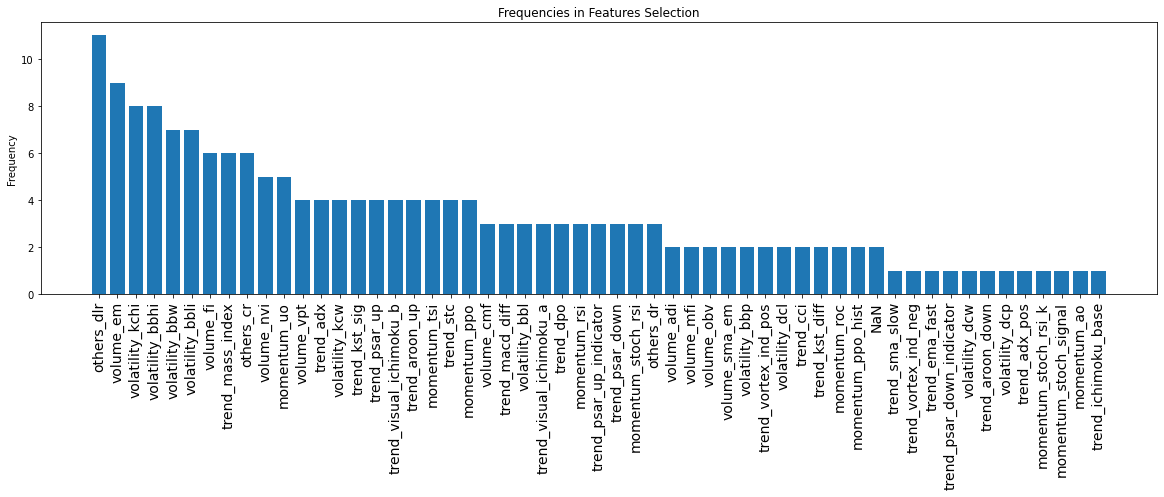

In [17]:
# Plot the dsitribution of apparition of the different features 
liste = Table_Selected_Features.values.tolist()
full_liste = []
for i in range(len(liste)):
    for j in range(len(liste[i])):
        full_liste.append(liste[i][j])
        
occurrences = collections.Counter(full_liste)
y = [count for tag, count in occurrences.most_common()]
x = [tag for tag, count in occurrences.most_common()]

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=10) 

f, ax = plt.subplots(figsize=(20,5))
plt.bar(x, y)
plt.title("Frequencies in Features Selection")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.savefig('Frequencies in Features Seleciton.pdf', bbox_inches='tight')
plt.show()




## DETAILED STEPS of the Features Selection function

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


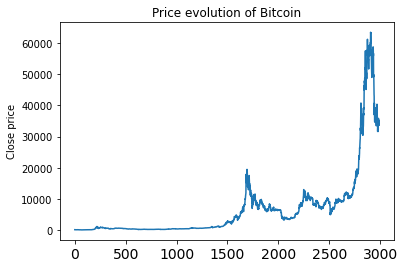

In [60]:
# load data 

Crypto = pd.read_csv("/Users/diego/OneDrive/Bureau/GitHub/ML_Finance/Crypto df/coin_Bitcoin.csv") 

# let's have a look at the data
plt.plot(Crypto["Close"])
plt.ylabel("Close price")
crypto_name = Crypto["Name"][0]
plt.title("Price evolution of " + crypto_name)
Crypto.head()

In [19]:
# Clean nan values

Crypto = ta.utils.dropna(Crypto)

# Add all technical analysis features filling nans values

Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)

#print(Cardano.columns)

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [20]:
Crypto

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
242,243,Bitcoin,BTC,2013-12-27 23:59:59,777.510010,713.599976,763.280029,735.070007,4.686270e+07,8.955395e+09,-1.537645e+07,4.686270e+07,-0.328117,0.000000e+00,0.000000,0.000000,-6.091301e+06,742.059998,50.000000,1000.000000,735.070007,735.070007,735.070007,0.000000,0.000000,0.0,0.0,742.059998,805.970032,678.149963,17.225032,0.445314,0.0,0.0,713.599976,777.510010,745.554993,8.694415,0.335941,0.000000,0.000000,0.000000,0.000000,0.000000,735.070007,735.070007,735.070007,735.070007,0.000000,0.000000,0.000000,-89.523154,1.000000,6545.202219,-899.032621,-899.032621,0.000000,745.554993,745.554993,745.554993,745.554993,0.000000,0.000000,0.000000,0.000000,0.000000,7158.248889,7044.852011,4.0,4.0,0.0,-1.000000,-1.000000,0.0,0.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.594148,33.594148,-66.405852,0.000000,0.000000,0.000000,0.000000,0.000000,735.070007,-89.903262,0.000000,0.000000
243,244,Bitcoin,BTC,2013-12-28 23:59:59,747.059998,705.349976,737.979980,727.830017,3.250580e+07,8.869919e+09,-1.284359e+07,1.435690e+07,-0.161822,-2.353417e+08,-2482.908219,-2482.908219,-4.245126e+07,735.788338,0.000000,990.150611,731.450012,738.690002,724.210022,1.979627,0.250000,0.0,0.0,734.403330,787.213359,681.593302,14.381751,0.437765,0.0,0.0,705.349976,777.510010,741.429993,9.865340,0.311530,0.000000,0.000000,-0.577549,-0.115510,-0.462039,731.450012,731.450012,733.956163,734.533712,0.005063,0.010919,-0.005856,-0.001924,1.943639,6548.822214,-899.529854,-899.281237,-0.248617,741.429993,741.429993,741.429993,741.429993,0.000000,0.000000,0.000000,0.000000,-66.666667,7158.248889,7044.852011,4.0,8.0,-4.0,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-100.000000,21.283876,31.153036,32.373592,-68.846964,0.000000,0.000000,-2.500653,-0.500131,-2.000522,731.817595,-0.984939,-0.989821,-0.984939
244,245,Bitcoin,BTC,2013-12-29 23:59:59,748.609985,714.440002,728.049988,745.049988,1.901130e+07,9.082104e+09,2.206332e+06,3.336820e+07,0.022427,-1.549537e+08,956.192156,-763.358031,1.296324e+05,735.835681,37.199037,1013.576912,735.983337,750.102589,721.864086,3.836840,0.821074,0.0,0.0,734.946662,781.543342,688.349982,12.680289,0.608413,0.0,0.0,705.349976,777.510010,741.429993,9.804574,0.550166,0.000000,0.000000,0.350210,-0.022366,0.372576,735.983337,735.983337,735.662905,735.312695,0.011550,0.015774,-0.004224,-0.000474,2.831246,6544.288889,-898.907168,-899.156548,0.249380,741.429993,741.429993,741.429993,741.429993,0.000000,0.000000,0.000000,0.000000,13.251992,7158.248889,7044.852011,12.0,8.0,4.0,-1.000000,777.510010,0.0,1.0,71.921234,0.000000,0.000000,0.000000,-94.850634,37.978405,55.016621,39.921268,-44.983379,0.000000,0.000000,-7.088933,-1.817891,-5.

In [21]:
# List of our indicators 

indicators = ['Date','volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [22]:
# compute the returns 

Crypto["Returns"] = Crypto["Close"].pct_change()

# keep only the relevant columns, ie. the ta indicators and the returns. 

Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN

Crypto

,Date,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,Returns
243,2013-12-28 23:59:59,-1.284359e+07,1.435690e+07,-0.161822,-2.353417e+08,0.000000,-2482.908219,-2482.908219,-4.245126e+07,990.150611,735.788338,0.000000,731.450012,738.690002,724.210022,1.979627,0.250000,0.0,0.0,734.403330,787.213359,681.593302,14.381751,0.437765,0.0,0.0,705.349976,777.510010,741.429993,9.865340,0.311530,0.000000,-0.577549,-0.115510,-0.462039,731.450012,731.450012,733.956163,734.533712,0.000000,0.000000,0.000000,0.005063,0.010919,-0.005856,-0.001924,1.943639,-66.666667,6548.822214,-899.529854,-899.281237,-0.248617,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,4.0,8.0,-4.0,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,21.283876,31.153036,32.373592,-68.846964,0.000000,731.817595,0.000000,-2.500653,-0.500131,-2.000522,-0.984939,-0.989821,-0.984939,-0.009849
244,2013-12-29 23:59:59,2.206332e+06,3.336820e+07,0.022427,-1.549537e+08,37.199037,956.192156,-763.358031,1.296324e+05,1013.576912,735.835681,0.000000,735.983337,750.102589,721.864086,3.836840,0.821074,0.0,0.0,734.946662,781.543342,688.349982,12.680289,0.608413,0.0,0.0,705.349976,777.510010,741.429993,9.804574,0.550166,0.000000,0.350210,-0.022366,0.372576,735.983337,735.983337,735.662905,735.312695,0.000000,0.000000,0.000000,0.011550,0.015774,-0.004224,-0.000474,2.831246,13.251992,6544.288889,-898.907168,-899.156548,0.249380,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,12.0,8.0,4.0,-1.000000,777.510010,0.0,1.0,0.000000,71.921234,0.000000,0.000000,0.000000,-94.850634,37.978405,55.016621,39.921268,-44.983379,0.000000,738.216009,0.000000,-7.088933,-1.817891,-5.271042,2.365933,2.338379,1.357691,0.023659
245,2013-12-30 23:59:59,6.464174e+06,5.407590e+07,0.054281,-1.000401e+08,55.625599,2787.135170,420.139703,7.577494e+05,1013.576912,739.050431,0.000000,741.020004,762.325663,719.714345,5.750360,0.854601,0.0,0.0,739.790827,781.328334,698.253321,11.229527,0.696680,0.0,0.0,705.349976,777.510010,741.429993,9.737933,0.703714,0.000000,1.956971,0.373502,1.583470,741.020004,741.020004,738.811690,736.854718,0.000000,0.000000,0.000000,0.019325,0.016967,0.002359,0.006118,3.661183,115.325833,6539.252222,-898.215344,-898.921247,0.705903,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,16.0,8.0,8.0,-1.000000,776.248610,0.0,0.0,0.000000,81.260429,0.000000,0.000000,0.000000,-87.732937,41.516721,70.371404,52.180354,-29.628596,0.000000,746.502271,0.000000,-10.620253,-3.578364,-7.041890,1.487151,1.476201,2.865033,0.014872
246,2013-12-31 23:59:59,1.510844e+07,3.317860e+07,0.107929,-9.207753e+07,42.962004,-433.779509,206.659900,2.493640e+05,1013.576912,740.822352,0.000000,743.618005,765.323734,721.912277,5.837871,0.739384,0.0,0.0,742.016663,

In [23]:
# standardize

sc = StandardScaler()
Z_Crypto_train = sc.fit_transform(Crypto.iloc[:,1:])

In [24]:
# Lasso regression (alpha = 1.0)

from sklearn.linear_model import Lasso
regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
#print(regLasso1)

In [25]:
# Rename for clarity 
# We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date

X,y = pd.DataFrame(Z_Crypto_train[:-1,:-1]),pd.DataFrame(Z_Crypto_train[1:,-1:])

In [26]:
# fit

regLasso1.fit(X,y)

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Lasso(fit_intercept=False, normalize=False)

In [27]:
# obtain coeffficients of the LASSO regression for multiple alphas
from sklearn.linear_model import lasso_path
alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33702039463105393, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2893979007485541, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39865333910756817, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.193278792944966, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1932817519655146, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1906023758929223, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3232136341453042, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3236610193193883, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.322959329474088, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\li

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.524524318607746, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9368531902496215, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.422464791725815, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.96669287695113, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.6870718722148, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.33761180954389, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\s

C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.10016684595394, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.31176687889342, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.62188810880502, tolerance: 0.2747906874134652
  model = cd_fast.enet_coordinate_descent_multi_task(
C:\Users\diego\anaconda3\envs\myenv\lib\

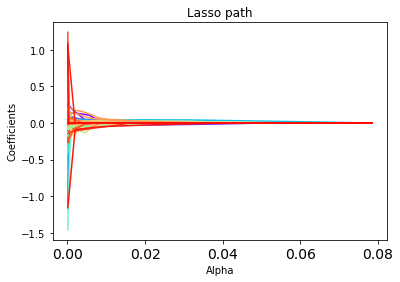

In [28]:
# graph of lasso path (coefficients given alpha)
import matplotlib.cm as cm
couleurs = cm.rainbow(np.linspace(0,1,len(indicators)))
for i in range(coefs_lasso.shape[1]):
    plt.plot(alpha_for_path,coefs_lasso[0][i,:],c=couleurs[i])
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.savefig('lasso path.pdf', bbox_inches='tight')
plt.show()

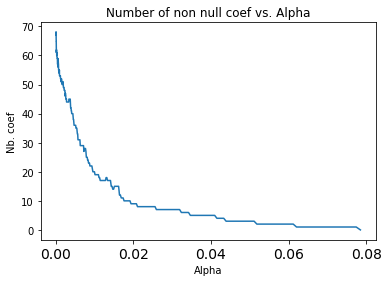

In [29]:
# number of non-nul coefficients for each alpha

nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})

plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. coef') 
plt.title('Number of non null coef vs. Alpha') 
plt.savefig('non zero coef.pdf', bbox_inches='tight')
plt.show()

In [30]:
# get the alpha for which we get 8 selected features (and its index)
# If no such alpha exists, choose an alpha for which we get 7 selected features, etc...

alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
while np.isnan(higher_alpha_to_get_8_features) == True :
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
index_higher_alpha_to_get_8_features

81

In [31]:
higher_alpha_to_get_8_features

0.025588019392882133

In [32]:
# get the 8 selected features coressponding 

coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
selected_features

['volume_mfi',
 'volatility_bbl',
 'volatility_kcp',
 'trend_cci',
 'trend_visual_ichimoku_b',
 'trend_psar_down',
 'momentum_rsi',
 'others_dr']

In [33]:
Z = Crypto['Date']
Z = np.array(Z)

# Long-Short term memory


In [36]:
sc = MinMaxScaler(feature_range = (0,1))
y = Crypto[['Returns']]
y = sc.fit_transform(y)
X = Crypto[Table_Selected_Features['Bitcoin']]
X = sc.fit_transform(X)
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7
0,0.520644,0.000000,0.0,0.929691,0.000000,0.0,0.000000,0.659321
1,0.546767,0.018294,0.0,0.929354,0.083333,0.0,0.000000,0.707566
2,0.560674,0.037142,0.0,0.928979,0.125000,0.0,0.000000,0.695068
3,0.536209,0.038004,0.0,0.928785,0.125000,0.0,0.000000,0.669599
4,0.550369,0.055959,0.0,0.928441,0.208333,1.0,0.000000,0.706722
...,...,...,...,...,...,...,...,...
2743,0.525640,0.270525,0.0,0.168530,0.291667,0.0,0.688444,0.687632
2744,0.577088,0.256257,0.0,0.246718,0.250000,0.0,0.847041,0.706292
2745,0.586988,0.225167,0.0,0.355681,0.208333,0.0,0.973694,0.699333
2746,0.485469,0.182023,0.0,0.450392,0.166667,0.0,0.619650,0.608909


In [37]:
#Setting The training set ratio
train_split = 80

#Rounding the training set length to avoid fractions
train_len = round(len(X)*(train_split/100))

#Setting the Test set length
test_len = round(len(X)-train_len)

#Splitting the data based on the calculated lengths
train_df = X.head(train_len)
test_df = X.tail(test_len)

#Printing the shapes of training and test sets

print("Shape Of Training Set :", train_df.shape)
print("Shape Of Test Set :", test_df.shape)

Shape Of Training Set : (2198, 8)
Shape Of Test Set : (550, 8)


In [38]:
#dataset_train['Date'] = pd.to_datetime(dataset_train['Date'])

#dataset_train.set_index('Date', inplace = True)
#dataset_train.sort_values(by='Date',ascending=True, inplace = True)



In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional, Reshape, CuDNNLSTM
from keras.layers import Dropout
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
"""
### Turn each signal into a labeled dataset
"""
#window_size = 30   # num. days per training sample
#batch_size = 128   # num. of samples per epoch
#buffer_size = 1000 # num of samples in memory for random selection
#split_time = 1748  # where to split the data for training/validation
#sequence_length = 50
#lookback = sequence_length - 1
#
#def window_dataset(series, window_size, batch_size, shuffle_buffer):
#    """Funtion to turn time series data into set of sequences 
#    where the last value is the intended output of our model"""
#    ser = tf.expand_dims(series, axis=-1)
#    data = tf.data.Dataset.from_tensor_slices(series)
#    data = data.window(window_size + 1, shift=1, drop_remainder=True)
#    data = data.flat_map(lambda w: w.batch(window_size + 1))
#    data = data.shuffle(shuffle_buffer)
#    data = data.map(lambda w: (w[:-1], w[1:]))
#    return data.batch(batch_size).prefetch(1)
#
#
#X_train = X.iloc[:split_time,:]
#X_test = X.iloc[split_time:,:]
#y_train = y.iloc[:split_time,:]
#y_test = y.iloc[split_time:,:]
#print(f"Training data shape: {X_train.shape}")
#print(f"Validation data shape: {X_test.shape}")
#
#train_set = window_dataset(X_train,window_size,batch_size,buffer_size)

'\n### Turn each signal into a labeled dataset\n'

In [40]:
sc = MinMaxScaler(feature_range = (0,1))

def process_data(unprocess_data , length_senquence, column = 1):
  
  #Select the feature/column 
  data = unprocess_data.iloc[:, column].values
  data = data.reshape(-1, 1)
    
  #Feature Scaling
  data = sc.fit_transform(data)
 
  
  #Making sequences
  
  X = []
  y = []

  for i in range(length_senquence, len(data)):
      X.append(data[i-length_senquence:i, 0])
      y.append(data[i, 0])
  X, y = np.array(X), np.array(y)

  # Reshaping
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  
  return X, y

In [41]:
#Setting the sequence length (Try different values)
sequence_length = 50

#Choosing the idex of the Close column
comumn_index= 3

#Preprocessing the training set
X_train, y_train = process_data(Crypto , sequence_length, comumn_index)

In [42]:
X_train.shape

(2698, 50, 1)

In [43]:
y_train.shape

(2698,)

In [44]:
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [45]:
#Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae', 'mape'])

In [46]:
regressor.fit(X_train, y_train, epochs = 15, batch_size = 50)

Epoch 1/15
54/54 [==============================] - 10s 77ms/step - loss: 0.0306 - mse: 0.0306 - mae: 0.1349 - mape: 73298.6250
Epoch 2/15
54/54 [==============================] - 4s 70ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0997 - mape: 95399.2031
Epoch 3/15
54/54 [==============================] - 4s 68ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0901 - mape: 92205.1641s - loss: 0.0135 -
Epoch 4/15
54/54 [==============================] - 4s 68ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0796 - mape: 93531.1875
Epoch 5/15
54/54 [==============================] - 4s 69ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0751 - mape: 89951.7031s - loss
Epoch 6/15
54/54 [==============================] - 4s 69ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0722 - mape: 83330.7969
Epoch 7/15
54/54 [==============================] - 4s 69ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0703 - mape: 71843.6875
Epoch 8/15
54/54 [==============================] - 4s 68ms/step - loss: 0.0076 - ms

In [47]:
#Converting the Date colum values from object to datetime format
#dataset_test['Date'] = pd.to_datetime(dataset_test['Date'])

In [48]:
#dataset_test.set_index('Date', inplace = True)

In [49]:
#dataset_test.sort_values(by='Date',ascending=True, inplace = True)
train_df

,0,1,2,3,4,5,6,7
0,0.520644,0.000000,0.0,0.929691,0.000000,0.0,0.000000,0.659321
1,0.546767,0.018294,0.0,0.929354,0.083333,0.0,0.000000,0.707566
2,0.560674,0.037142,0.0,0.928979,0.125000,0.0,0.000000,0.695068
3,0.536209,0.038004,0.0,0.928785,0.125000,0.0,0.000000,0.669599
4,0.550369,0.055959,0.0,0.928441,0.208333,1.0,0.000000,0.706722
...,...,...,...,...,...,...,...,...
2193,0.539318,0.076307,0.0,0.440599,0.083333,0.0,0.807753,0.648124
2194,0.538833,0.076393,0.0,0.441877,0.041667,0.0,0.028046,0.653777
2195,0.539381,0.076428,0.0,0.439978,0.000000,0.0,0.056962,0.674994
2196,0.538079,0.080380,0.0,0.464886,0.541667,0.0,0.000000,0.629786


In [50]:
test_set = pd.concat((train_df.tail(sequence_length), test_df), axis = 0)

In [51]:
test_set.shape

(600, 8)

In [52]:
test_set

,0,1,2,3,4,5,6,7
2148,0.538202,0.105966,0.0,0.465130,0.208333,0.0,0.000000,0.637242
2149,0.539097,0.108805,0.0,0.463639,0.166667,0.0,0.078700,0.683667
2150,0.540255,0.115228,0.0,0.467529,0.125000,0.0,0.116425,0.678276
2151,0.537486,0.125661,0.0,0.464745,0.083333,0.0,0.000000,0.627537
2152,0.537179,0.141381,0.0,0.434026,0.041667,0.0,0.000000,0.655563
...,...,...,...,...,...,...,...,...
2743,0.525640,0.270525,0.0,0.168530,0.291667,0.0,0.688444,0.687632
2744,0.577088,0.256257,0.0,0.246718,0.250000,0.0,0.847041,0.706292
2745,0.586988,0.225167,0.0,0.355681,0.208333,0.0,0.973694,0.699333
2746,0.485469,0.182023,0.0,0.450392,0.166667,0.0,0.619650,0.608909


In [53]:
x_test, y_true = process_data(test_set , sequence_length, comumn_index)


In [54]:
x_test

array([[[0.46513007],
        [0.46363865],
        [0.46752865],
        ...,
        [0.43997781],
        [0.46488637],
        [0.45245809]],

       [[0.46363865],
        [0.46752865],
        [0.46474493],
        ...,
        [0.46488637],
        [0.45245809],
        [0.44903314]],

       [[0.46752865],
        [0.46474493],
        [0.43402608],
        ...,
        [0.45245809],
        [0.44903314],
        [0.44372464]],

       ...,

       [[0.33136278],
        [0.6639881 ],
        [0.63029116],
        ...,
        [0.46171137],
        [0.16853017],
        [0.24671757]],

       [[0.6639881 ],
        [0.63029116],
        [0.74608399],
        ...,
        [0.16853017],
        [0.24671757],
        [0.35568121]],

       [[0.63029116],
        [0.74608399],
        [0.91542096],
        ...,
        [0.24671757],
        [0.35568121],
        [0.45039201]]])

In [55]:
#Predicting the closing price of the test data
predicted_price = regressor.predict(x_test)

In [56]:
#Inversing the scaled values 
predicted_price = sc.inverse_transform(predicted_price)

In [57]:
#Inversing the scaled actual prices from test data
crypto_price = sc.inverse_transform(y_true.reshape(-1, 1))

In [58]:
# A Method to plot predicted pirce vs Actual price
def predicted_plot(crypto_price, predicted_price, title, x_label, y_label):
  plt.plot(crypto_price, color = 'green', label = 'Real Crypto Price')
  plt.plot(predicted_price, color = 'red', label = 'Predicted Crypto Price')
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Bitcoin Stock Price')
  plt.legend()
  plt.show()

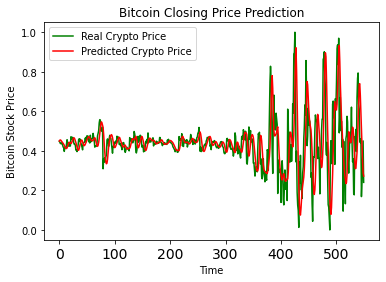

In [59]:
predicted_plot(crypto_price, predicted_price, "Bitcoin Closing Price Prediction", "Time", "Closing Price")


In [90]:
predicted_price = pd.DataFrame(predicted_price)
crypto_price = pd.DataFrame(crypto_price)

In [91]:
predicted_price['positive?'] = np.where(predicted_price>=0.5, 1, 0)
predicted_price

,0,positive?
0,0.449525,0
1,0.454159,0
2,0.455304,0
3,0.452973,0
4,0.448797,0
...,...,...
545,0.521388,1
546,0.431578,0
547,0.346955,0
548,0.289292,0


In [92]:
crypto_price['positive?'] = np.where(crypto_price>=0.5, 1, 0)
crypto_price

,0,positive?
0,0.449033,0
1,0.443725,0
2,0.436830,0
3,0.437335,0
4,0.436148,0
...,...,...
545,0.168530,0
546,0.246718,0
547,0.355681,0
548,0.450392,0


In [105]:
df = np.where(predicted_price['positive?']==crypto_price['positive?'],1,0)
np.sum(df)
len(predicted_price)


SyntaxError: invalid syntax (Temp/ipykernel_15348/1752442063.py, line 4)

In [97]:
for i in len((predicted_price)):
    crypto_price['positive2'] = np.where(crypto_price[i+1]>=crypto_price[i], 1, 0)
    i=i+1

TypeError: 'int' object is not iterable

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(lookback,return_sequences=True), input_shape=(lookback,X_train.shape[-1]),))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM((lookback*2), return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(lookback, return_sequences=False)))

model.add(Dense(32, activation='relu'))
model.add(Activation('tanh'))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
### Turn each signal into a labeled dataset
"""
window_size = 30   # num. days per training sample
batch_size = 128   # num. of samples per epoch
buffer_size = 1000 # num of samples in memory for random selection
split_time = 1400  # where to split the data for training/validation


def window_dataset(series, window_size, batch_size, shuffle_buffer):
    """Funtion to turn time series data into set of sequences 
    where the last value is the intended output of our model"""
    ser = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer)
    data = data.map(lambda w: (w[:-1], w[1:]))
    return data.batch(batch_size).prefetch(1)


x_train = X[:split_time,:]
x_test = X[split_time:,:]

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_test.shape}")

train_set = window_dataset(x_train,window_size,batch_size,buffer_size)

In [346]:
$ source activate tensorflow_p36

SyntaxError: invalid syntax (<ipython-input-346-bb134744341d>, line 1)

In [279]:
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [280]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X)
X_normalized_min_max = min_max_scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized_min_max, y, test_size= 0.15, shuffle=False)
model = LinearRegression()

# Fit model
model.fit(X_train,y_train)

# Predict CO2 values
preds = model.predict(X_test)

In [281]:
#def compute_Pi(X,y, n_splits=1000):
"""
    Computes the 95% CI intervals based on TimeSeries cross validation bootstrapping.
    Returns an array of shape (2, nbr samples).
    
    Parameters
    ==========
    X: (numpy.ndarray)
        Features array of the data of the whole data 
    y: (numpy.ndarray)
        Daily returns of the wole data
    
        
    Returns
    ==========
    Pi: (numpy.ndarray)
        Arrays of tuples with the 2.5th and the 97.5th percentile
        
"""
tscv = TimeSeriesSplit(n_splits=10)
results = np.empty(len(y))

# Bootstrap over TimeSeries splits
for train_index, test_index in tscv.split(X) :
    # Get sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Train model
    model_tmp = LinearRegression().fit(X_train, y_train)
    # Compute predictions
    preds = model_tmp.predict(X_test)
    print(preds)
    # Store predictions
    #results = np.c_[results, preds]

# Get 95% PI of predictions
#Pi = np.percentile(results, [2.5, 97.5], axis=1)
#return Pi

# Return the predictions
Pi = preds
#return Pi
#
#PI = compute_Pi(X,y)
#

[[-8.91894000e-04]
 [ 3.45539123e-03]
 [ 2.17265089e-03]
 [-2.82175310e-03]
 [-1.53496654e-02]
 [-1.79756323e-02]
 [-3.97560712e-02]
 [-4.20128554e-02]
 [-6.14361875e-03]
 [-1.09318394e-02]
 [-6.93959446e-03]
 [ 2.17726532e-02]
 [ 7.97633965e-03]
 [-4.57816652e-03]
 [-6.35573605e-03]
 [-5.08318363e-03]
 [-2.03842659e-02]
 [-9.89971730e-03]
 [-4.37147113e-04]
 [-1.38046936e-03]
 [-8.34309280e-03]
 [-1.69786737e-02]
 [-3.13485733e-02]
 [-3.04029002e-02]
 [-5.65298361e-03]
 [-3.29075882e-03]
 [ 1.00852987e-02]
 [ 1.65680199e-02]
 [ 6.46345059e-03]
 [ 5.66191615e-03]
 [ 1.47924417e-02]
 [ 1.90323410e-02]
 [ 1.69047643e-02]
 [ 4.04365912e-03]
 [-2.14423037e-03]
 [ 2.27365296e-03]
 [ 1.55554633e-02]
 [ 9.92439948e-03]
 [-1.25736799e-04]
 [ 5.15689276e-03]
 [-1.25939314e-03]
 [-2.73268712e-02]
 [-2.10821785e-02]
 [-2.02721679e-02]
 [-9.92002916e-03]
 [-9.30886738e-03]
 [-5.50443085e-03]
 [-2.51970198e-02]
 [-1.02396800e-02]
 [-1.19760256e-02]
 [-2.58363063e-02]
 [-1.89268103e-02]
 [-1.0149299

In [263]:
y_test

,Returns
2742,0.017309
2743,-0.003184
2744,-0.013585
2745,0.029505
2746,0.013147
...,...
2986,0.009679
2987,0.022760
2988,0.017861
2989,-0.043692


In [245]:
#create a DF for the PI array
PI =pd.DataFrame(PI)
PI

,0
0,-0.022199
1,0.011300


In [204]:
#create an array with the days to plot the graphs
z = np.arange(0,2748,1)
z = np.vstack(z)
z=pd.DataFrame(z)
z


,0
0,0
1,1
2,2
3,3
4,4
...,...
2743,2743
2744,2744
2745,2745
2746,2746


In [205]:
y.index -=243
y = pd.DataFrame(y)


ValueError: x and y must have same first dimension, but have shapes (2748, 1) and (2, 2)

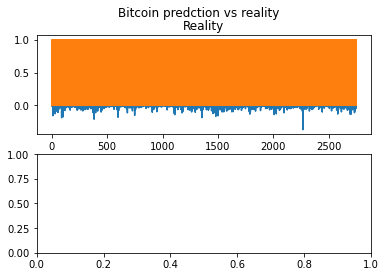

In [206]:
# plot our predictions vs the truth
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle('Bitcoin predction vs reality')
ax1.plot(z, y)
ax1.title.set_text('Reality')
ax2.plot(z,PI)
ax2.title.set_text('Prediction')
fig.tight_layout(pad=2.0)

In [198]:
#create a new column in the y df which takes 1 if the return is prositive, and 0 otherwise
y['positive?'] = np.where(y['Returns']>=0, 1, 0)
y

,Returns,positive?
0,-0.009849,0
1,0.023659,1
2,0.014872,1
3,-0.002804,0
4,0.023063,1
...,...,...
2743,0.009679,1
2744,0.022760,1
2745,0.017861,1
2746,-0.043692,0


In [199]:
#create a new column in the PI df which takes 1 if the return is prositive, and 0 otherwise
PI['positive?'] = np.where(PI[0]>=0, 1, 0)
PI

,0,positive?
0,-0.025292,0
1,-0.004941,0
2,0.006617,1
3,-0.007734,0
4,0.006006,1
...,...,...
2743,0.002298,1
2744,0.035746,1
2745,0.045044,1
2746,-0.022199,0


In [163]:
#Compare the two columns, and each time they ended up taking the same value, we return 1, and 0 otherwise
df = np.where(PI['positive?']==y['positive?'],1,0)
np.sum(df)

1861

In [ ]:
## Plot Pi evolution
def plot_Pi_evolution(df_actual_pi, preds_array, Pi_array, title="") : 
    """
    Plot the actual profits measurements against the predictions with 95% CIs.
    
    Parameters
    ===========
    df_actual_pi: (pd.DataFrame) DataFrame containing the actual Profits measurements in a "Pi" column.
    preds_array: (np.array) Array containing the Profits predictions. Must be of same length as df_actual_pi.
    pi_array: (np.Array) Array containing the confidence intervals. Must be of shape (2, length of df_actual_pi).
    """
    # Isolate PI measurements
    df_plot_Pi_drifty = df_actual_pi.copy()
    #display(df_plot_PI_drifty.head(1))

    # Isolate predictions
    df_plot_Pi_preds = df_plot_Pi_drifty.copy()
    df_plot_Pi_preds["Returns"] = preds
    # Add PI
    df_plot_Pi_preds["Pi"] = Pi_array[1,:] - Pi_array[0,:]
    #display(df_plot_PI_preds.head(1))
    df_plot_Pi_compare = pd.concat([df_plot_Pi_drifty.assign(origin="Real"), 
                                     df_plot_Pi_preds.assign(origin="Predicted")])\
                            .sort_index()\
                            .fillna(0)\
                            .reset_index()
    

    #display(df_plot_Pi_compare.head(4))

    # Plot 
    fig = px.line(df_plot_Pi_compare,
                  x="timestamp",
                  y="Pi",
                  color="origin",
                  error_y='Pi',
                  category_orders={"origin":["Predicted", "Real"]},
                  title=title,
                  )
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50))
    fig.show()
        
plot_Pi_evolution(Crypto['Returns'], preds, Pi, title="Profits estimated vs real")

In [ ]:
# Get a nicer visualization with matplotlib for Confidence Intervals

def plot_Pi_evolution_nice(df, preds, Pi, title):
    


    fig, ax = plt.subplots(figsize=(18, 8))

    # Plotting of lines
    ax.plot(dates, preds, label='Pi Predictions')
    ax.plot(dates, Pi[0], 'b', alpha=0.3)
    ax.plot(dates, Pi[1], 'b', alpha=0.3)
    ax.plot(dates, y, 'r', label='Pi Measurements')
    ax.fill_between(dates, Pi[0], Pi[1], alpha=.3)

    ax.legend()
    ax.set_title('Pi Measurements vs Pi Predictions with 95% Confidence Interval', fontsize=18)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Pi')
    
    fig.suptitle(title, fontsize=22)
    fig.show()
    
plot_Pi_evolution_nice(df, preds, Pi, title='Returns predictions')

In [ ]:
#
